# On-Policy Monte Carlo control with first-visit e-soft policy

This exercice is 5.8 from the book "Reinforcement Learning: an itroduction. From Sutton and Barto. The problem is extracted from the book as following:

___

Consider driving a race car around a turn like those shown in Figure 5.5. You want to go as fast as possible, but not so fast as to run off the track. In our simplified racetrack, the car is at one of a discrete set of grid positions, the cells in the diagram. The velocity is also discrete, a number of grid cells moved horizontally and vertically per time step. The actions are increments to the velocity components. Each may be changed by +1, −1, or 0 in one step, for a total of nine actions. Both velocity components are restricted to be nonnegative and less than 5, and they cannot both be zero except at the starting line. Each episode begins in one of the randomly selected start states with both velocity components zero and ends when the car crosses the finish line. The rewards are −1 for each step until the car crosses the finish line. If the car hits the track boundary, it is moved back to a random position on the starting line, both velocity components are reduced to zero, and the episode continues. Before updating the car’s location at each time step, check to see if the projected path of the car intersects the track boundary. If it intersects the finish line, the episode ends; if it intersects anywhere else, the car is considered to have hit the track boundary and is sent back to the starting line. To make the task more challenging, with probability 0.1 at each time step the velocity increments are both zero, independently of the intended increments. Apply a Monte Carlo control method to this task to compute the optimal policy from each starting state. Exhibit several trajectories following the optimal policy (but turn the noise off for these trajectories).

___

We will use an On-Policy first-visit Monte Carlo control with e-soft to solve this problem. A brief summary of each of the terms is explained below:

- Monte Carlo Control: Refers to a set of methods that do not require a perfect model to work. Contrary to the dynamic programming approach, they don't try to use a model to estimate the value function iteartively via the Bellman Equation. Instead, they learn from past experience and calculate thev values as the averaged returns of the state-values actions. Also, they follow two steps of policy evaluation and improvement like the Dynamic Programming approach.  
- On-Policy: Means that the policy used to learn is the same that is used to explore the problem, instead of being two separated ones. Furthermore, the policy is updated at each iteration with a greedy behaviour. This approach may stuck in a local minima if the policy is deterministic.
- e-soft: refers to a technique used to avoid getting stuck in a local minima when we didin't even tried to optimal action for a specific state. e-soft approaches give to every action a chance to ocur at every state, even if they are not theoretically optimal. (See projects/Blackjack\ and\ Monte\ Carlo\ Methods.ipynb for more information about this).

___

Below there is a simple implementation of the problem. To make things more interesting, instead of surpasing the finish line, the car has to exactly finish in the final position.

In [1]:
"""We import some useful libraries"""
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math

In [48]:
def initialization():
    """
    This function creates the necessary components for Monte Carlo Control approach.
    It returns:
        The state-value function Q.
        The policy pi
        The racetracks for the problems, maps.
        The set of possbile actions to their representation, A.
        The set of representations of A to their actions, _A.
    """
    task_1 = np.array([(9,14),(9,14),(9,14),(9,15),(9,15),(9,15),(9,15),(9,15),(9,15),(9,15),(9,16),(9,16),(9,16),(9,16),(9,16),(9,16),(9,16),(9,16),(9,17),(9,17),(9,17),(9,17),(9,17),(9,17),(9,17),(8,17),(1,17),(1,17),(1,16),(1,15),(1,15),(1,14)])
    task_2 = np.array([(10,32),(10,32),(10,32),(10,31),(10,30),(10,29),(10,28),(10,27),(10,26),(10,25),(10,24),(10,23),(10,22),(10,21),(10,20),(10,19),(10,18),(9,18),(7,18),(6,18),(3,18),(1,19),(1,20),(1,21),(1,22),(1,22),(1,22),(1,22),(1,20),(1,17)])
    Q = np.zeros([32,32,11,11,9])
    pi = np.zeros([32, 32,11,11], dtype=np.int8)
    A = {}
    i = 0
    for vx in range(-1,2):
        for vy in range(-1,2):
            A[(vx,vy)] = i
            i += 1
    _A = {A[key]:key for key in A.keys()}
    a = np.zeros([32, 32])
    for column, rows in enumerate(reversed(task_1)):
        a[column, -rows[1]:-rows[0]] = 1
    a[0:6,-2] = 2
    b = np.zeros([32, 32])
    for column, rows in enumerate(reversed(task_2)):
        b[column, -rows[1]:-rows[0]] = 1
    b[0:9, -2] = 2
    maps = [a,b]
    return Q, pi, maps, A, _A

In [3]:
def reset_position(task_number):
    """
    This function is used to reset the position of the car to a valid starting position. It returns the 
    new (x,y) position of the car.
    The parameter task_number is the map number to use, either 1 or 2.
    """
    if task_number == 1:
        position = [31, np.random.choice(np.where(maps[0][-1,:] == 1)[0]),0,0]
    if task_number == 2:
        position = [28, np.random.choice(np.where(maps[1][-3,:] == 1)[0]),0,0]
    return position

In [4]:
def compute_next_position(position, speedh, speedv, task_number, verbose = False):
    """
    This functions computes the next position given the following parameters:
    -position: the current position (x,y).
    -speedh: the current horizontal speed.
    -speedv: the current vertical speed.
    -task_number: the map thas is being used, can be either 1 or 2.
    -verbose: if True, prints relevant information for debugging.
    The function returns the next position, whether the position is a winning position and whether the 
    car exit the track.
    """
    length = maps[0].shape[0]
    if verbose: print('Trying to move from ', position, 'to ', position[0] + speedv, position[1]+speedh, 'in map', task_number)
    task_number -= 1
    posible_position = (position[0] + speedv,(position[1] + speedh))
    position[2] = speedv + 5
    position[3] = speedh + 5
    if verbose: print('Trying to move to:', posible_position)
    if abs(posible_position[0]) >= length or abs(posible_position[1]) >= length or posible_position[0] < 0 or  posible_position[1] < 0:
        if posible_position[1] >= length and posible_position[0] in np.where(maps[1][:, -3] == 1)[0]: #Exit the map but crossed the line
            position[1] = posible_position[1]
            if verbose: print('Won, crossed the line')
            return position, True, False
        else:
            position = reset_position(task_number+1)
            if verbose: print('Invalid horizontal move. Position will be', position)
            return position, False, True
    if maps[task_number][posible_position[0],posible_position[1]] == 1:
        position[1] = posible_position[1]
    elif maps[task_number][posible_position[0],posible_position[1]] == 2:
        position[1] = posible_position[1]
        position[0] = min(posible_position[0], 31)
        if verbose: print('Won, ended in the line. Possible position:',posible_position,'value: ',maps[task_number][posible_position[0],posible_position[1]] )
        return position, True, False
    else:
        position = reset_position(task_number+1)
        if verbose: print('Invalid horizontal move. Position will be', position)
        return position, False, True
    if maps[task_number][posible_position] == 1:
        position[0] = posible_position[0]
    else:
        position = reset_position(task_number+1)
        if verbose: print('Invalid vertical move. Position will be', position)
        position, False, True
    return position, False, False

In [46]:
def generate_episode(task_number, pi,A ,e, show_graphic, verbose= False):
    """
    This functions generates an episode of the racetrack, defined as the period between the start and reaching and end.
    The parameters are:
     -task_number: the map thas is being used, can be either 1 or 2.
     -pi: the policy used.
     -A: the set of actions.
     -e: the e-soft parameters. Is the probabilities of selecting a random action instead of following the policy.
     -show_graphic: if True, plots a graphic of each position visited. Only for debugging, makes the process much slower.
     -verbose:  if True, prints relevant information for debugging.
    Return the set of states, actions and rewards of the episode. 
    """
    state = reset_position(task_number)
    if verbose:print('Initial position', state)
    actions = []
    rewards = []
    states = []
    v1 = 0
    v2 = 0
    while True:
        if random.random() > e:
            a1, a2 = _A[pi[state[0], state[1],state[2], state[3]]]
            if verbose: print('Following policy actions', a1, a2)
        else:
            a1, a2 = _A[np.random.choice(range(0, 9))]
            if verbose: print('Moving at random', a1, a2)
        v1 = min(max(v1+a1, -5),5)
        v2 = min(max(v2+a2, -5),5)
        states.append(tuple(state))
        state, won, restart = compute_next_position(state, v1, v2,task_number, verbose=verbose)
        if show_graphic:
            previous = maps[task_number-1][state[0], state[1]]
            maps[task_number-1][state[0], state[1]] = 3
            sns.heatmap(maps[task_number-1])
            plt.show()
            maps[task_number-1][state[0], state[1]] = previous
        if restart:
            v1 = 0
            v2 = 0
        actions.append((a1, a2))
        if not won:
            rewards.append(-1)
        else:
            rewards.append(0)
            return states, actions, rewards   

In [47]:
def first_visit_MC_control(task_number,pi,A,Q,e, iterations, e_decay = False, verbose = False):
    """
    Performs the MC control with first visit and e-soft policy. Can also include a decay for the e-soft policy.
    The parameters are:
    -task_number: the map thas is being used, can be either 1 or 2.
     -pi: the policy used.
     -A: the set of actions.
     -Q: The state-value function Q.
     -e: the e-soft parameters. Is the probabilities of selecting a random action instead of following the policy.
     -iterations: the amount of iterations to train the model.
     -e_decay: whether to reduce the e at each step.
    It returns
     -Q: the state-value function Q calculated as the averaged returns of the first visit to every state-action
         pair.
    -pi: the optimal policy for the generated Q.
    """
    times_seen = {}
    performance = []
    for iteration in range(iterations):
        print('\r iteration: ', iteration+1, e, end = '')
        states, actions, rewards = generate_episode(task_number, pi,A ,e, False, verbose = verbose)
        performance.append(len(states))
        Q, times_seen = policy_evaluation(Q, states, actions, rewards, times_seen, verbose = verbose)
        for s in set(states):
            pi[s[0],s[1], s[2], s[3]] = Q[s[0], s[1], s[2], s[3]].argmax()
        if e_decay:
            e = (1 - (iteration+1)/iterations)**2
    return Q, pi, performance

In [7]:
def policy_evaluation(Q, states, actions, rewards, times_seen, verbose = False):
    length = len(rewards)
    seen = {}
    for index, s, a, r in zip(range(length), states, actions,rewards):
        if verbose: print('State - Action Pair', s, a)
        if (s,a) in seen: 
            if verbose: print('State - Action Pair already seen')
            continue
        else:
            seen[s,a] = 1
            G = -1*(length - index - 1)
            if verbose: print('G', G)
            if (s,a) in times_seen:
                Q[s][A[a]] = (Q[s][A[a]] * times_seen[s,a] + G) / (times_seen[s,a] + 1)
                times_seen[s,a] += 1  
            else:
                times_seen[s,a] = 1
                Q[s][A[a]] = G
    return Q, times_seen

In [49]:
#First, we initiate the starting values.
Q1, pi1, maps, A, _A = initialization()

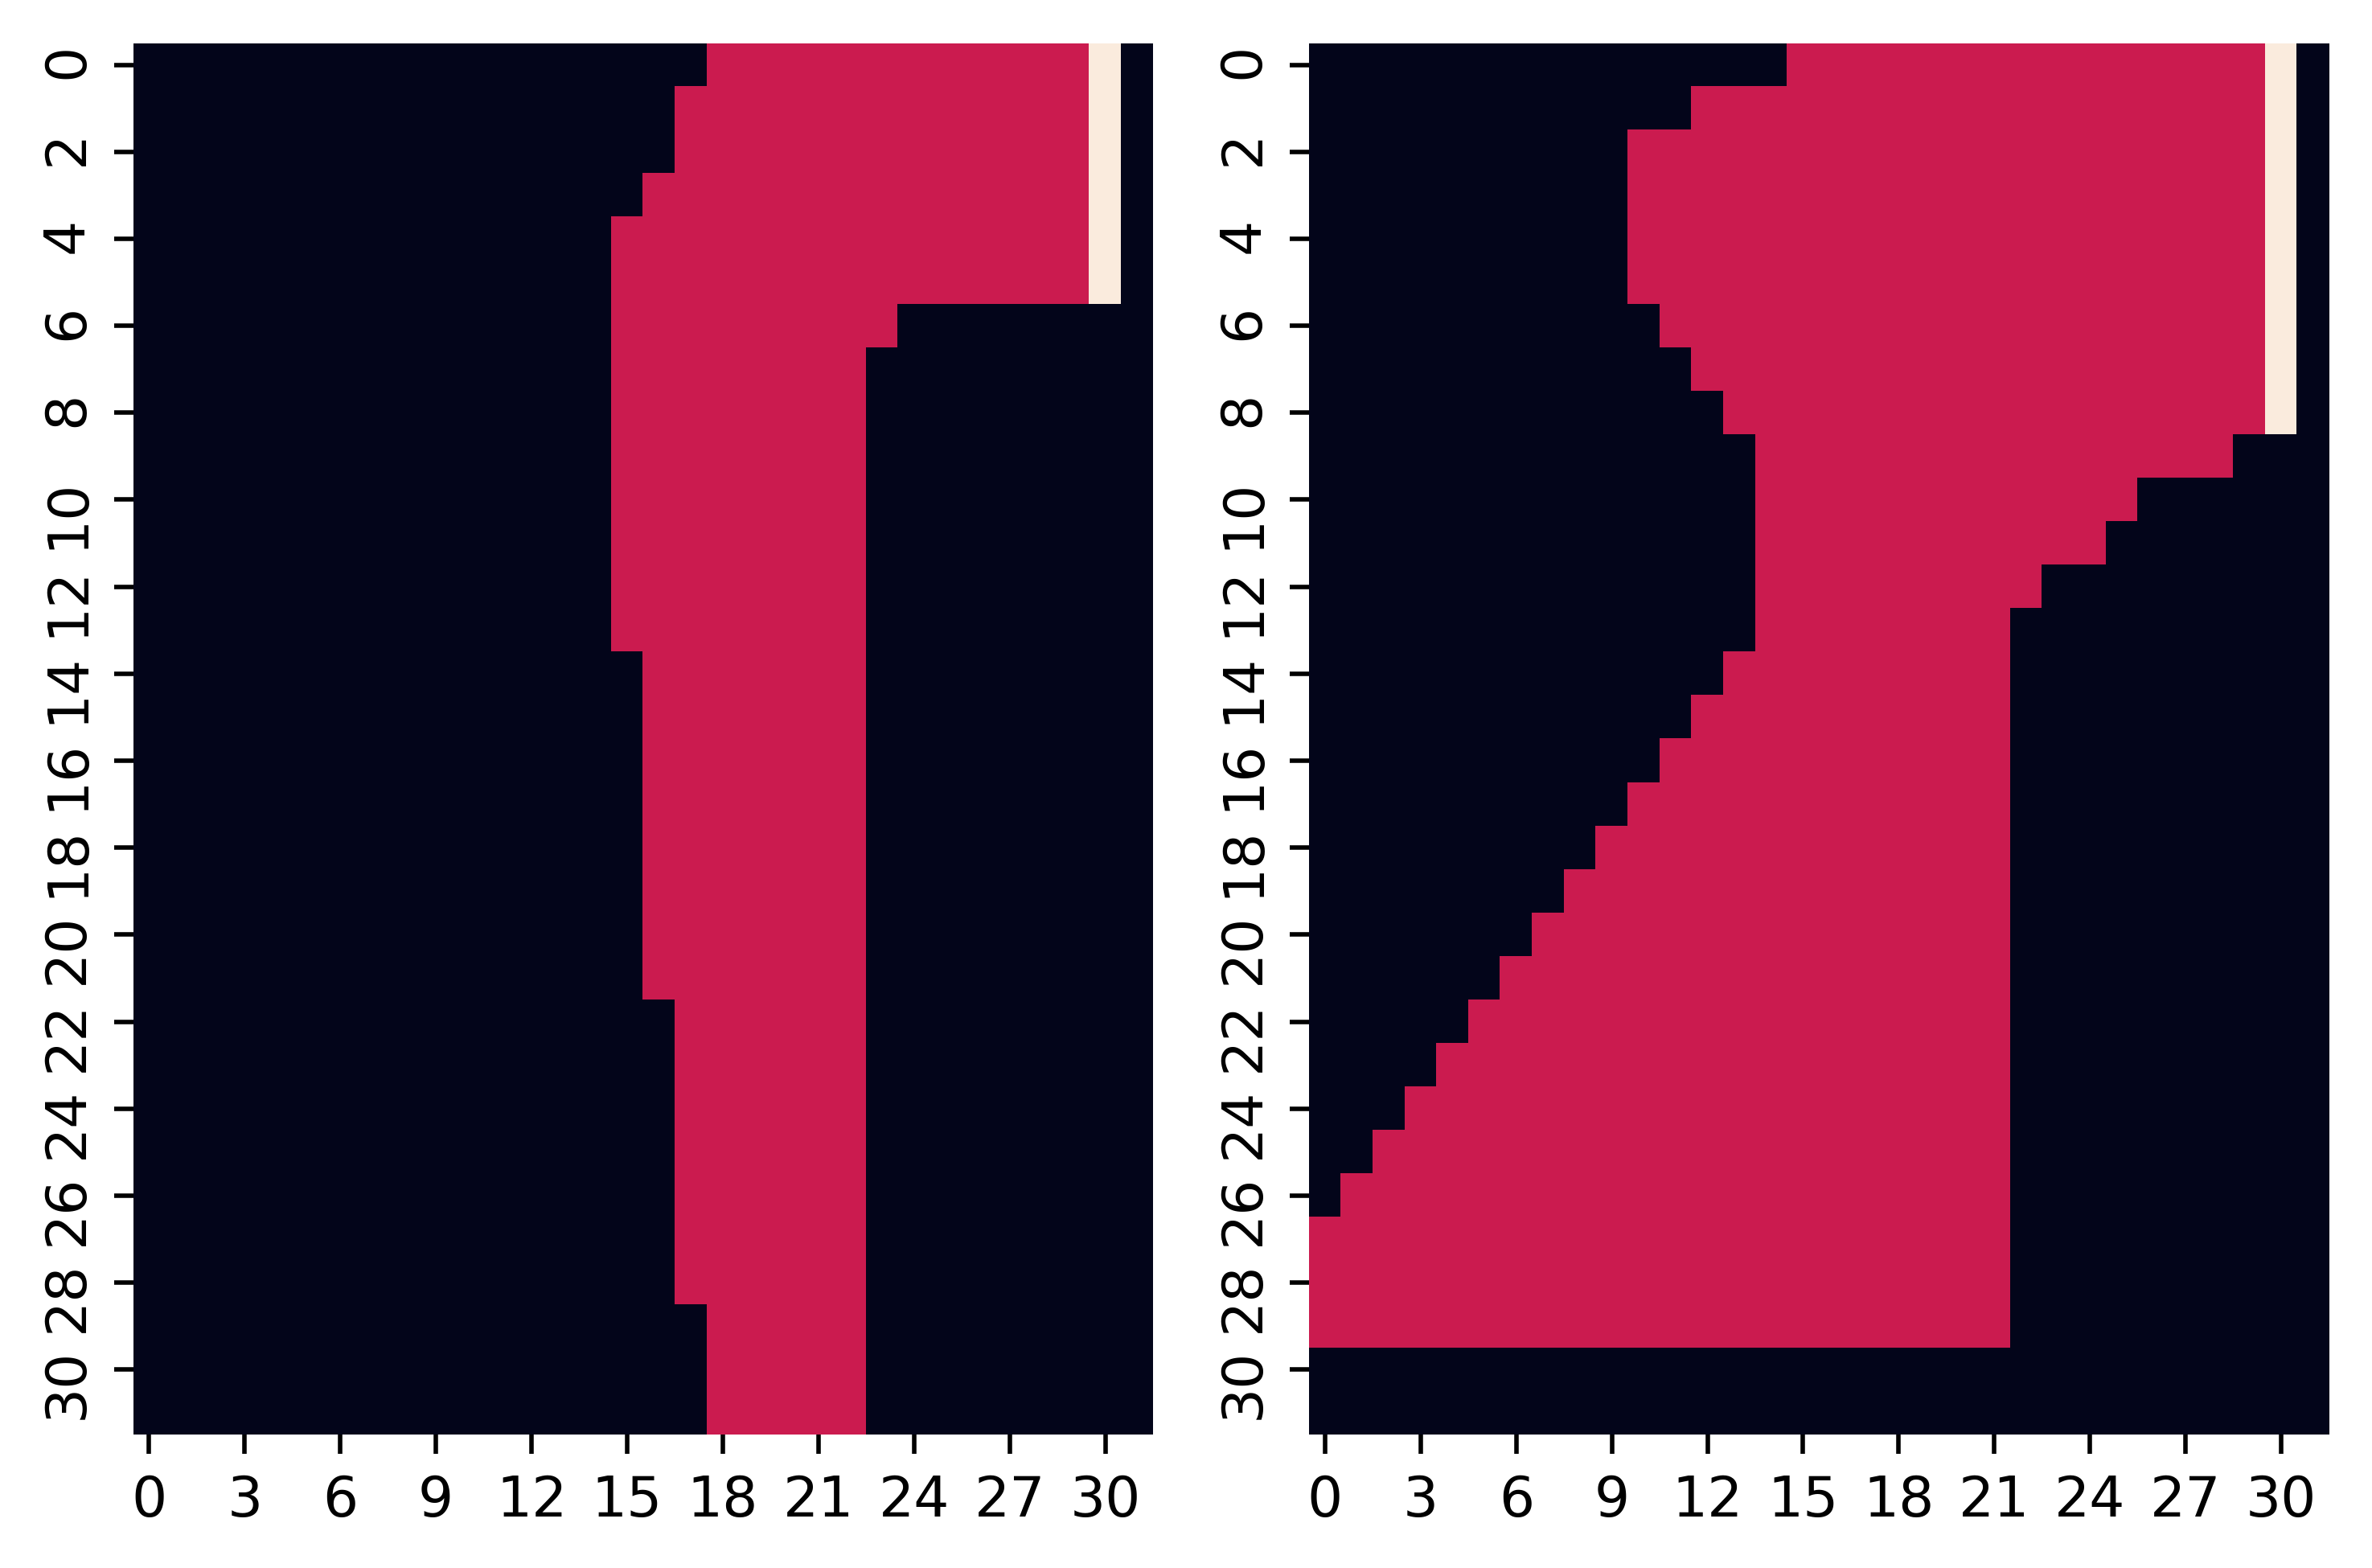

In [9]:
#We can check that the tracks have de desired shape. The white squares are the finishing line.
plt.subplots(dpi = 500)
plt.subplot(1,2,1)
sns.heatmap(maps[0], cbar=False)
plt.subplot(1,2,2)
sns.heatmap(maps[1], cbar = False)
plt.tight_layout()
plt.show()

In [10]:
Q1, pi1, performance1 = first_visit_MC_control(1,pi1, A,Q1, 0.9, 10000, True, False)

 iteration:  10000 9.999999999997797e-09.9710131600000002 8268 0.030032890000000003 8790 0.014665209999999996 0.0079923600000000060.0031472100000000044

In [11]:
#We do the same for the second map
Q2, pi2, maps, A, _A = initialization()
Q2, pi2, performance2 = first_visit_MC_control(2,pi2, A,Q2, 0.9, 10000, True, False)

 iteration:  10000 9.999999999997797e-09060899600000001 4450 0.3081360099999999 5308 0.22024249000000004 6452 0.12595401 7577 0.05875775999999998 0.0203062499999999880.011924639999999992 9865 0.00018495999999999853

We can check how good the performance has improved over a random policy be looking at how many steps do the robot require to reach the end at each iteration of the training.

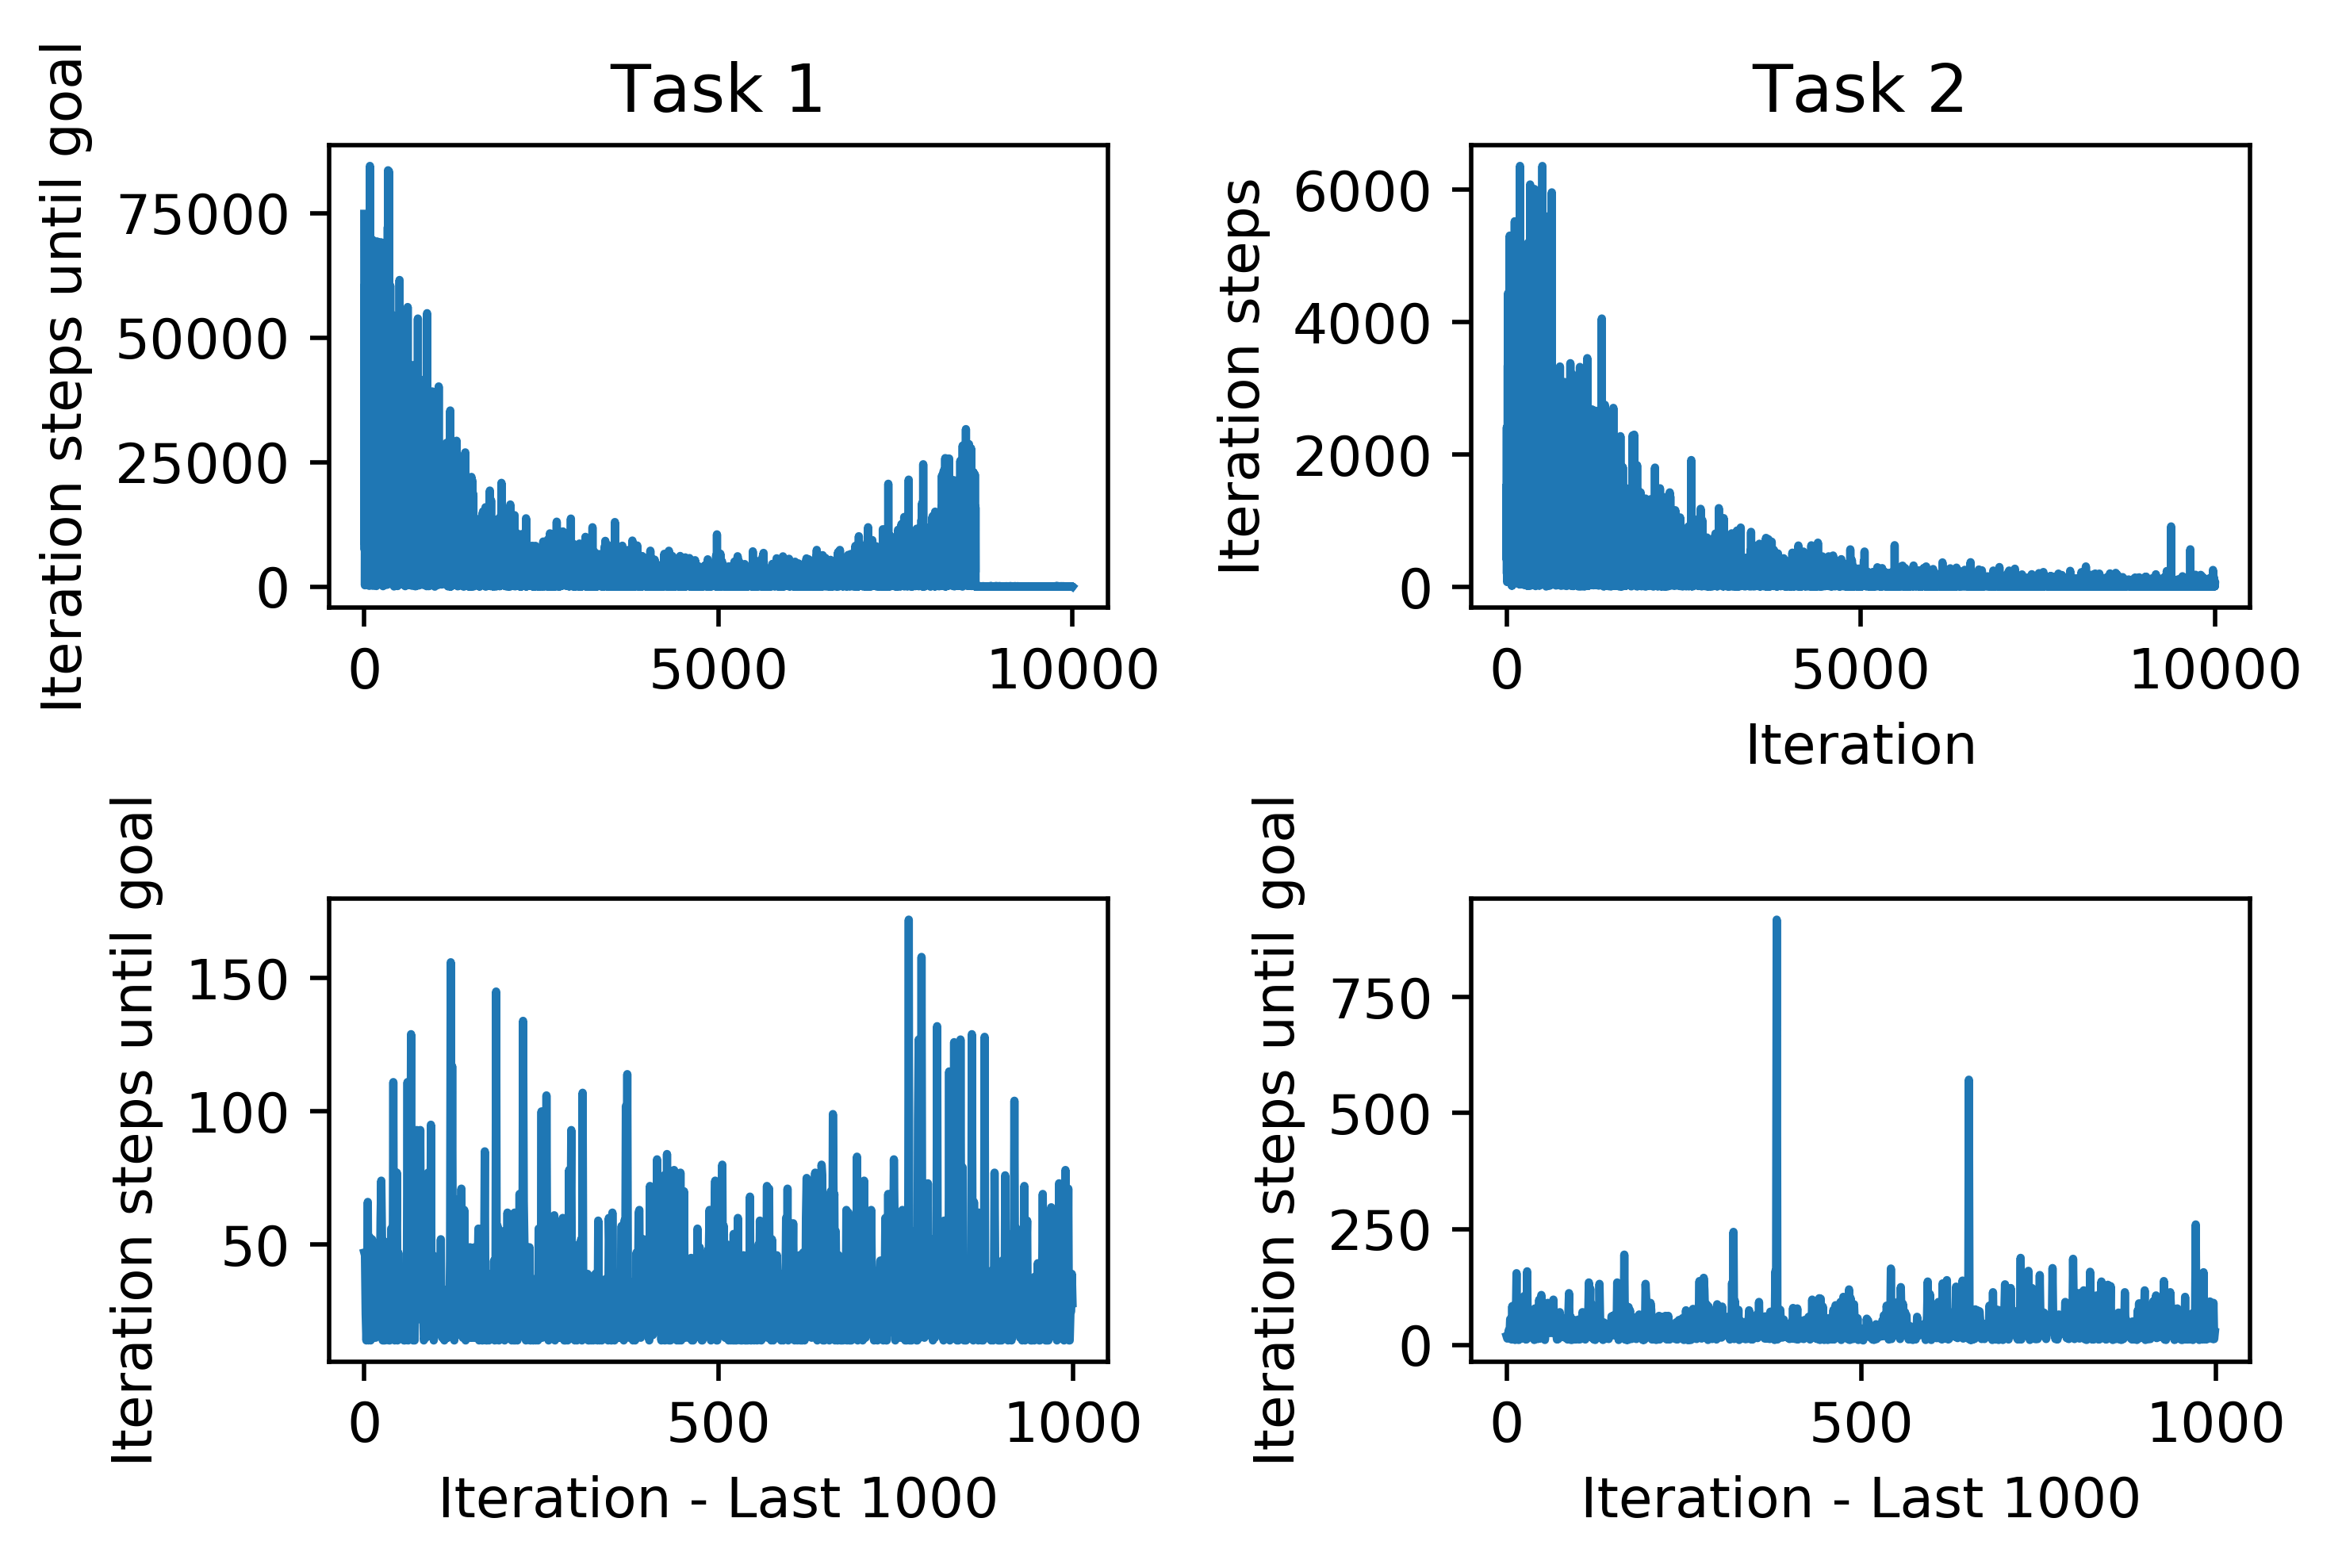

In [16]:
plt.subplots(dpi = 500)
plt.subplot(2,2,1)
plt.plot(performance1)
plt.title('Task 1')
plt.ylabel('Iteration')
plt.ylabel('Iteration steps until goal')
plt.subplot(2,2,2)
plt.title('Task 2')
plt.plot(performance2)
plt.xlabel('Iteration')
plt.ylabel('Iteration steps')
plt.subplot(2,2,3)
plt.plot(performance1[-1000:])
plt.xlabel('Iteration - Last 1000')
plt.ylabel('Iteration steps until goal')
plt.subplot(2,2,4)
plt.plot(performance2[-1000:])
plt.xlabel('Iteration - Last 1000')
plt.ylabel('Iteration steps until goal')
plt.tight_layout()
plt.show()

We can see how the robot finds it much easier to learn the second task rather than the first, probably because the first one has more narrow paths and thefore it is easy to start over again many times before reaching the goal.
Interestingly enough, both task are solved in average with about 50 moves when the robot has learned how to do it. 

We can further improve the result by training with a lot of iterations at a very low random rate.

In [30]:
iQ1, ipi1, iperformance1 = first_visit_MC_control(1,pi1, A,Q1, 0.05, 50000, False, False) # i stands for improvement 
iQ2, ipi2, iperformance2 = first_visit_MC_control(2,pi2, A,Q2, 0.05, 50000, False, False) # i stands for improvement 

 iteration:  463 0.05

 iteration:  50000 0.051279 0.05 1630 0.05 2463 0.05 2940 0.05 3296 0.05 3732 0.05 4129 0.05 4962 0.05 5453 0.05 5795 0.05 0.05 6652 0.05 8046 0.050.05 0.059960 0.05 10460 0.050.05 0.0512959 0.05 13459 0.050.05 0.0515958 0.05 16458 0.050.05 0.0518957 0.05 19457 0.050.05 0.0521956 0.05 22456 0.050.05 0.0524955 0.05 25455 0.050.05 0.0527954 0.05 28454 0.050.05 0.0530953 0.05 31453 0.050.05 0.0533952 0.05 34452 0.050.05 0.0536951 0.05 37451 0.050.05 0.0539950 0.05 40450 0.050.05 0.0542949 0.05 43449 0.050.05 0.0545948 0.05 46448 0.050.05 0.0548947 0.05 49447 0.05 280 0.050.05 0.052779 0.05 3279 0.050.05 0.055778 0.05 6278 0.050.05 0.058777 0.05 9277 0.050.05 0.0511776 0.05 12276 0.050.05 0.0514775 0.05 15275 0.050.05 0.0517774 0.05 18274 0.050.05 0.0520773 0.05 21273 0.050.05 0.0523772 0.05 24272 0.050.05 0.0526771 0.05 27271 0.050.0529770 0.05 30270 0.050.05 0.0532769 0.05 33269 0.050.05 0.0535768 0.05 36268 0.050.05 0.0538767 0.05 39267 0.050.05 0.0541766 0.05 42266 0.050.05 0.0544765 0

In [43]:
print('Average number of moves to win after the final training for task 1',np.array(iperformance1[-1000:]).mean())
print('Average number of moves to win after the final training for task 2',np.array(iperformance2[-1000:]).mean())

Average number of moves to win after the final training for task 1 12.591
Average number of moves to win after the final training for task 2 10.46


We get probably the optimal (or close to it), result. We can check it by visualizing the movments that the robot performs during a simulation like the following ones.

### Task 1 simulation

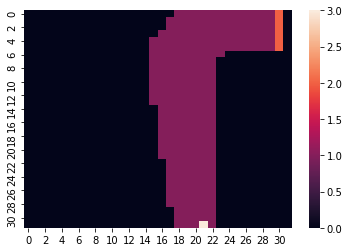

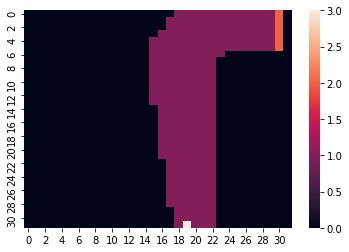

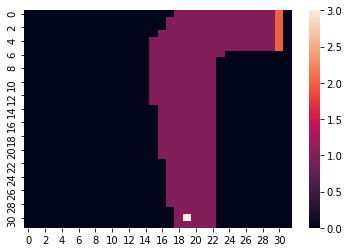

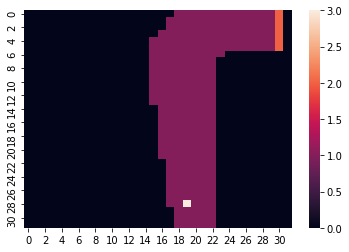

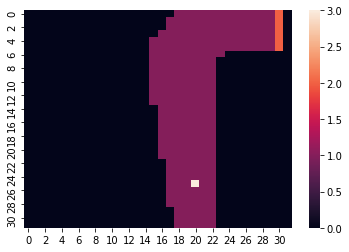

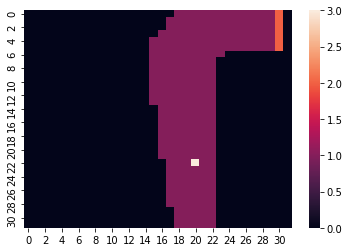

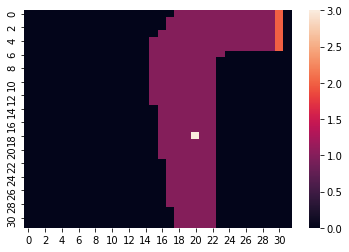

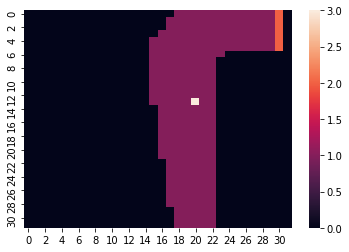

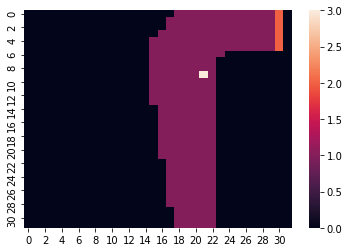

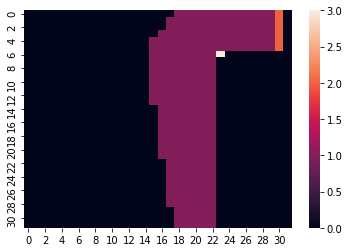

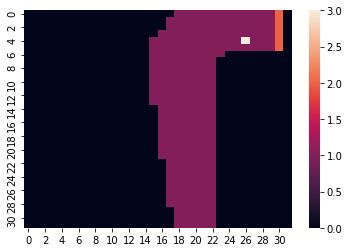

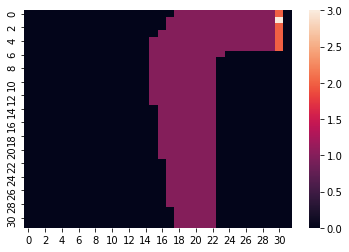

In [51]:
_, _, _ = generate_episode(1, ipi1,A ,0, show_graphic = True, verbose= False)

### Task 2 simulation

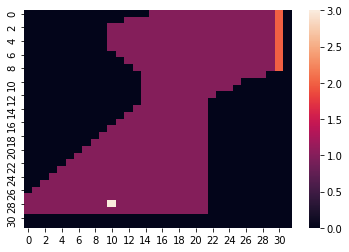

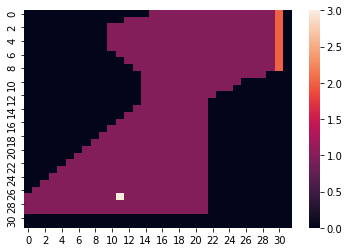

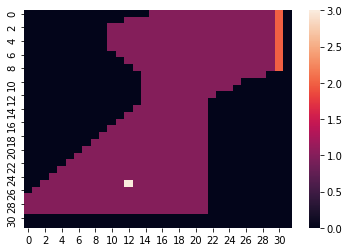

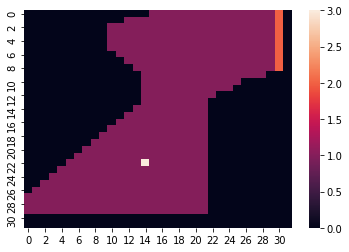

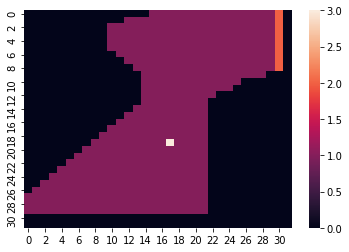

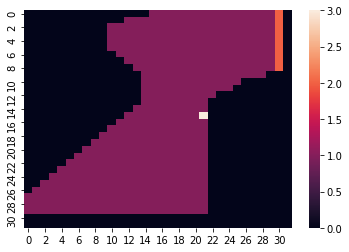

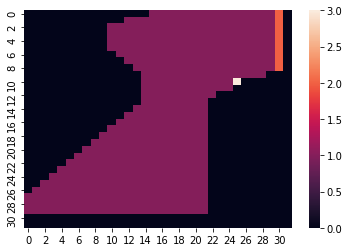

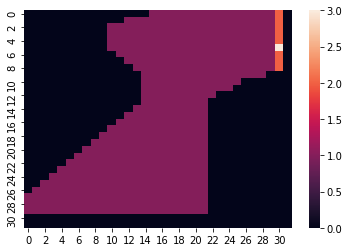

In [52]:
_, _, _ = generate_episode(2, ipi2,A ,0, show_graphic = True, verbose= False)

As we can see in the examples, the robot takes the optimal route.